<a href="https://colab.research.google.com/github/FrancescoZanni/MLPNS_FZanni/blob/main/FittingLineToGRBAfterglows_instructionsEsercitazioneWeek3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    
  **TL;DR: we measure a quantity named magnitude over time, which is an inverse logaritmic measure of brightness of the GRB, and which is expected to change it roughly linearly with the logarithm of time.**

_About GRB Afterglows_

*Gamma-ray bursts (GRBs) are bright X-ray and gamma-ray flashes observed in the sky, emitted by distant extragalactic sources. They are associated with the creation or merging of neutron stars or black holes; processes which result in an explosive outburst of material moving incredibly close to the speed of light [ref](https://www.mpg.de/16999277/0607-kern-gammarayburst-153865-x#:~:text=It%20was%20this%20afterglow%20emission,the%20form%20of%20synchrotron%20photons). Long after the initial burst of gamma rays has subsided, gamma ray bursts (GRBs) are still observable at less energetic wavelengths. Although no formal definition exists, this smoothly varying, lower energy radiation that may be visible for several days following the GRB itself, is usually referred to as the GRB afterglow.*


    
  **Details**: *The light that we measure from these explosions changes over time, so we can study its time series. The change in light is exponential, not linear, but if we take the logarithm of the light, that chance may be linear, since the logarithm is the inverse of exponent. The logarithm of the light flux is called magnitude in astronomy. A line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process.*
    
*It is believed that the afterglow originates in the external shock produced as the blast wave from the explosion collides with and sweeps up material in the surrounding interstellar medium. The emission is synchrotron emission produced when electrons are accelerated in the presence of a magnetic field. The successive afterglows at progressively lower wavelengths (X-ray, optical, radio) result naturally as the expanding shock wave sweeps up more and more material causing it to slow down and lose energy.*

*X-ray afterglows have been observed for all GRBs, but only about 50% of GRBs also exhibit afterglows at optical and radio wavelengths [ref](https://astronomy.swin.edu.au/cosmos/G/gamma+ray+burst+afterglow)*

  *In reality, the correct model is a  broken powerlaw: the slope of the line "breaks" or changes, at some point in time. But this exercise is about fitting lines. But in the end we will use MCMC and find out which model is better*

# initial imports

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
#pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Task 1: Read and prepare the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

find the link to the *raw* input file on github in the HW1 folder https://github.com/fedhere/MLTSA_FBianco/tree/master/HW1

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/linearRegression/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


## Create the log-time variable

We will fit a line in log space. The magnitude column I gave you is the logarithm (base 10) of the flus so that is already available. Create a logarithm base 10 of the time variable

(Fitting a line in log-log space corresponds to fitting a powerlaw y=x^a in natural space. Note: we mean logbase 10, use ```numpy.log10()```)

If you have trouble with this look at this gist https://gist.github.com/fedhere/42956d318347def627f6ad750c3eee9a


In [3]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. If I wanted to retrieve all magnitudes for filter 'V' I would do ```grbAG.loc[grbAG["filter"] == f, "mag"]```.

Plot the data with different colors for different photometric bands. 

Use pl.errorbar to display the uncertainties in the data - if you do not know how to use pl.errorbar you can symply type

```pl.errorbar?``` in a cell to retrieve the help

In [4]:
pl.errorbar?

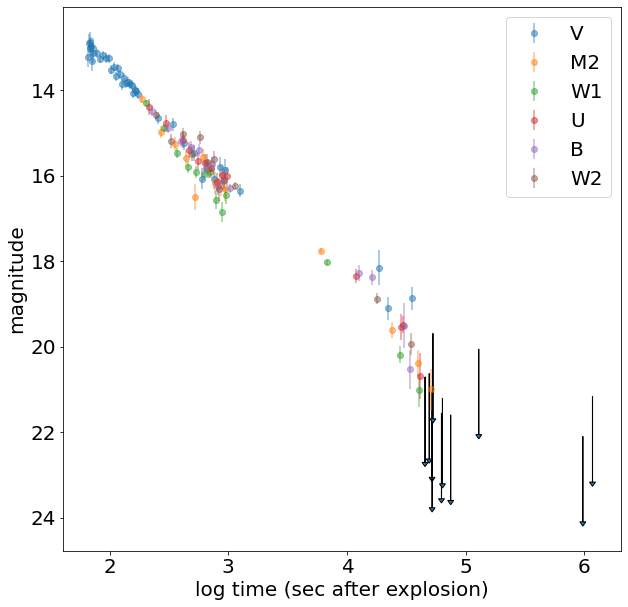

In [5]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"]==f].logtime,
    grbAG.loc[grbAG["filter"]==f].mag, fmt='o', alpha=0.5,
    yerr = grbAG[grbAG["filter"]==f].magerr,label=f)

#riguarda bene i dettagli tipo fmt e alpha!!
                
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.gca().invert_yaxis()
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);



Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

## Clean the data: Remove upper limits
This data includes upper limits which I plotted as downward errors. upper and lower limits (technically called "censored data" are extremely hard to deal with in modeling). For now, lets just remove them. 

To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```

If you do not know how to remove selected rows from a dataframe based on a condition look at this gist https://gist.github.com/fedhere/e9cd67d9dc0357ee547e03a12ceb4719

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 


# Task 2: Fit models to data
## Task 2a: Solve using the Normal Equation

You can use the code I put in the slides for this - you can copy and paste it but you will learn most if you try type it down and make sure you understand it line by line!!

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [6]:
grbAGnu = grbAG[grbAG.upperlimit == 0 ]


In [7]:
x = grbAGnu["logtime"].values

X = np.c_[np.ones((len(grbAGnu), 1)),x]

y = grbAGnu["mag"].values

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
#comincio a vedere come il pythonic style interferisce con la leggibilità, troppe operazioni in una volta

theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
                                           
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))
#l'asterisco è per spacchettare l'array, se non lo metto non funziona ricorda il puntatore del c

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X,y)
print("Secondo modo, intercetta=", lr.intercept_,"    coefficiente ", lr.coef_[1])

#c'era anche sotto ma ok 

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51
Secondo modo, intercetta= 8.582668233648771     coefficiente  2.511999838500421


## Task 2b: Fit a line to the data with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.





In [9]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression

#sklearn is an object oriented package. You will call the function which will create a model (model selection) then fit it to the data separately (model fitting)

lr = LinearRegression()
lr.fit(X,y)
       
#this will create new properties of the model instance: the intercept and coefficients!

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


## Optional Task 2c: Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.



best fit parameters from the minimization of L1: slope 2.64, intercept 8.23
best fit parameters from the minimization of L2: slope 2.51, intercept 8.58
Soluzione analitica di prima intercept 8.58, slope 2.51


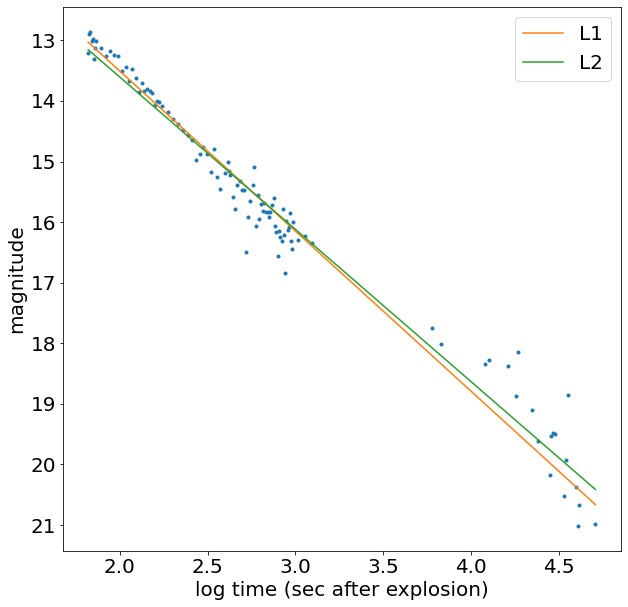

In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope*x+intercept

#DEVO mettere tutti i parametri che vanno ottimizzati all'interno dello stesso tuple, non potrei pasasrli uno a uno!
def l1(args, x, y):
    a, b = args
    return np.abs(y-line(a,b,x)).sum()
    #sommo perchè il risultato deve essere un numero, non il vettore delle distanze
  
def l2(args, x, y):
    a, b = args
    return ((y-line(a,b,x))**2).sum()

#Volendo aggiungo anche chisq, c'è su github, basta aggiungere il sigma


#(1,1) così convergono entrambi, potrei anche variare il metodo che utilizzo, quando chiamo la funzione minimize
initialGuess = (1,1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever

l1Solution = minimize(l1, initialGuess, args=(x, y))
l2Solution = minimize(l2, initialGuess, args=(x, y))


#print(l1Solution)
#print(l2Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))
print("best fit parameters from the minimization of L2: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))
print ("Soluzione analitica di prima " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

ax = pl.figure(figsize=(10,10)).add_subplot(111)

newx=np.array([np.min(x),np.max(x)])
pl.plot(x,y,'.')
#pl.plot(newx,line(newx,lr.intercept_,lr.coef_[1]),label="analytical") si sovrappone a L2!
pl.plot(newx,line(newx,l1Solution.x[1],l1Solution.x[0]),label="L1")
pl.plot(newx,line(newx,l2Solution.x[1],l2Solution.x[0]),label="L2")




pl.gca().invert_yaxis()
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);






## Optional task 2d: Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the Pearson's $\chi^2$ (chi squared) function as your objective function. The $\chi^2$ is the distance between prediction and truth, divided by the uncertainty (sigma squares) see slides or see slides or https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#:~:text=10%20References-,Definition,differs%20from%20a%20theoretical%20distribution.

In [20]:
def chi2(args, x, y, s):
 
    a, b = args
    return sum((y - line(x, a, b))**2 / s)

def Rsquare(args, x, y):
   
    a, b = args
    return (1 / x.shape[0]) * sum((y - line(x, a, b))**2) / np.std(y)**2





s = grbAGnu.magerr.values 

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 58.498374289483735
        x: [ 8.582e+00  2.500e+00]
      nit: 4
      jac: [ 4.768e-07  4.768e-06]
 hess_inv: [[ 1.113e-02 -3.813e-03]
            [-3.813e-03  1.398e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.58, intercept 2.50


##Train e test
mi manca definire la s come gli errori, va fatto quando faccio il chisquare

In [29]:
s=grbAG.magerr
#modo sbagliato, prendo i primi e testo con gli ultimi, così sto trasporanto il modello ottimizzato da una parte con quello ottimizzato all'inizio, non va bene
x_train, x_test, y_train, y_test, s_train,s_test=x[:75],x[75:],y[:75],y[75:],s[:75],s[75:]
#il modo corretto è quello di scegliere il subset a caso: 
from sklearn.model_selection import train_test_split
#
x_train, x_test, y_train, y_test, s_train,s_test = train_test_split(x,y,s,test_size=0.25,random_state = 420)

#check perchè non funziona




ValueError: ignored

# Task 3: Plot all the solutions MANCA!! recuperare


To do this best, you can create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.

If you do not know how to define a function look here. https://gist.github.com/fedhere/babc8d20533acb9288caf097138825bc


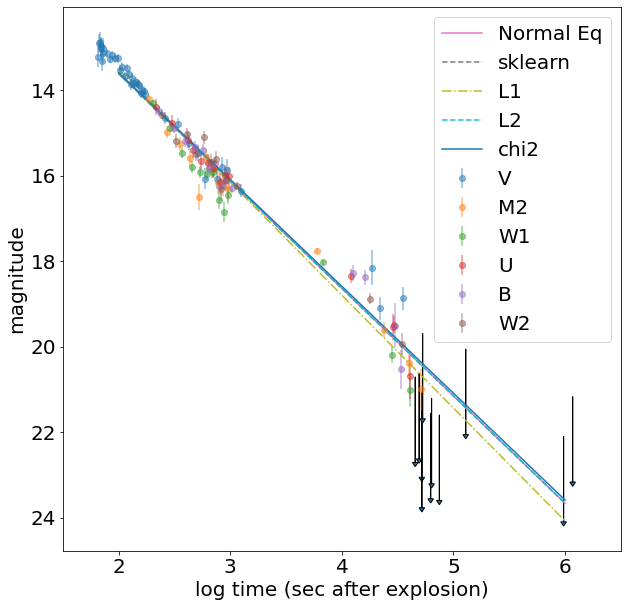

In [19]:
def plotline(x, intercept, slope, legend=None, symbol='-', ax=ax):
    ax.plot(x, line(x, intercept, slope), ls=symbol, label=legend)
    
newx = np.array([2, 6])
ax = pl.figure(figsize=(10,10)).add_subplot(111)


for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f].logtime,   
             grbAG[grbAG["filter"] == f].mag, fmt='o', alpha=0.5,
             yerr=grbAG[grbAG["filter"] == f].magerr, label=f)
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
# plot the datapoints as above as errorbars
# plot the upperlimits as arrows (see above)

#plot the models

#normal equation
plotline(newx, *theta_best, ax=ax, legend="Normal Eq")
         
#sklearn
plotline(newx, lr.intercept_, lr.coef_[1], ax=ax, legend="sklearn", symbol='--')
         
#minimize L1
plotline(newx, *[l1Solution.x[1],l1Solution.x[0]], ax=ax, legend="L1", symbol='-.')

#minimize L2
plotline(newx, *[l2Solution.x[1],l2Solution.x[0]], ax=ax, legend="L2", symbol='--')


#minimize chi2
plotline(newx, *chi2Solution.x, ax=ax, legend="chi2", symbol='-')

        
pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.gca().invert_yaxis()

pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

#LEZIONE 9, parto con train e test set: parte nuova


Il "modo sbagliato" quò essere il corretto modo di porcedere se sto facendo modelli predittivi, cioè se basandomi su dati del passato sto cercando di predire comportamenti futuri(es altezza mari fra 10 anni)
Nel nostro caso perç vogliamo che il modello rappresenti bene tutti i dati, quindi non ha senso prendere solo i tempi più piccoli, il modo corretto di procedere è scegliere il test set random

In [24]:

#modo sbagliato, prendo i primi e testo con gli ultimi, così sto trasporanto il modello ottimizzato da una parte con quello ottimizzato all'inizio, non va bene
x_train, x_test, y_train, y_test, s_train,s_test=x[:75],x[75:],y[:75],y[75:],s[:75],s[75:]
#il modo corretto è quello di scegliere il subset a caso: 
from sklearn.model_selection import train_test_split
#modo giusto!
x_train, x_test, y_train, y_test, s_train,s_test = train_test_split(x,y,s,test_size=0.25,random_state = 420)

#recupera l'inizio!



In [25]:
#ripeto le cose, ok 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, y, s, test_size=0.25, random_state=42)

chi2Solution = minimize(chi2, initialGuess, args=(x_train, y_train, s_train)) #train on the training set

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))



  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.75745016446026
        x: [ 8.664e+00  2.470e+00]
      nit: 4
      jac: [ 4.768e-07  8.583e-06]
 hess_inv: [[ 1.378e-02 -4.593e-03]
            [-4.593e-03  1.645e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47


cerco la soluzione usando il training test

In [22]:
  
l2Solution = minimize(l2, initialGuess, args=(x_train, y_train)) #train on the training set

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))
  

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.75745016446026
        x: [ 8.664e+00  2.470e+00]
      nit: 4
      jac: [ 4.768e-07  8.583e-06]
 hess_inv: [[ 1.378e-02 -4.593e-03]
            [-4.593e-03  1.645e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47


E verifico con il test set

In [39]:

l2(chi2Solution.x, x_test, y_test), l2(l2Solution.x, x_test, y_test)


#cosa che non ho fatto prima 
grbAGnu = grbAG[grbAG.upperlimit == 0] 
s = grbAGnu.magerr.values 




(108,)

#Passo al MCMC
Riscrittura delle cose che sono nell'altro notebook

In [26]:
#il pacchetto non è già disponibile su colab, devo installarlo come esterno
#il punto esclamativo è perchè pip non è un comando di pyton ma di unix (system command)
!pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 3.6 MB/s eta 0:00:00


In [27]:
import emcee
!pip install corner
#pacchetto per fare i grafici triangolari
import corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ricordo th bayes: 
$p(a,b|y)\sim p(y|a,b)*p(a,b)$

$p(a,b|y)$ è la posterior \\
$p(a,b)$ è il prior \\
$p(y|a,b)$ è la likelihood \\

faccio tutto in logaritmo così ho una somma e non un prodotto
$log(posterior)\sim log(prior)+log(likelihood)$


In [31]:
#ottimizzerò i logaritmi, il prodotto diventerà somma!
#i parametri sono in un tuple che chiamo theta


def log_prior(theta):
  slope,intercept =theta
  #come prior voglio che la slope sia positiva per come è correlata alla fisica, in più
  #è impossibile che magnitudini siano negative, troppo luminose per la loro distanza
  if slope > 0 and intercept > 0:
    #questo è il se sono nel prior, non ha importanza che valore passo
    return 0
  else: 
    #se sono fuori voglio qualcosa che sia imbattibile negativamente, quindi ritorno meno infinito
    return -np.inf

#sto utilizzando un semi informative prior, che rimuove certe zone del parameter space
#unico effetto del prior è di invalidare le zone sbagliate




def log_likelihood(theta, x, y, yerr):
  #è la probabilità dei dati dato il modello, è la target function che ho usato ieri
  #la scrivo come il mio chisquared, se assumo gaussianità 
  slope,intercept =theta
  return -np.sum(((line(x,intercept,slope) - y)**2)/yerr**2)
  
  

def log_probability(theta,x,y,yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf #evito di calcolare la log likelihood se già ho infinito
  else: 
    return lp+log_likelihood(theta,x,y,yerr)



In [33]:
#initial guess
ig=[10,1]
#numero di catene in parallelo, legato alle possibilità del pc e dalla dimensione dello spazio dei parametri
#hyperparameter!
nwalkers = 32

#dimensione dello spazio dei parametri
ndim = len(ig) 

#posizione iniziale, non cominciano tutte nello stesso posto ma quasi, un po di randomness
np.random.seed(420)
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers,ndim)   #1e-4 rule of thumb






In [41]:
#inizializzo un oggetto della classe 
#log prob deve per forza avere come primo argomento la tupla dei parametri, gli altri valori, sui quali non ottimizzo li passo anche alla classe 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (x,y,s))

In [42]:
#faccio partire le catene
sampler.run_mcmc(pos,5000, progress=True)  #5000 a caso poi controllo se effettivamente è stato sufficiente

100%|██████████| 5000/5000 [00:08<00:00, 621.13it/s]


State([[2.47667545 8.60459432]
 [2.51710289 8.50381236]
 [2.49256646 8.55986529]
 [2.48580021 8.58063442]
 [2.46474642 8.62815297]
 [2.48201669 8.60125492]
 [2.48905004 8.58715083]
 [2.49645    8.56794081]
 [2.47544312 8.60769204]
 [2.47702954 8.60028841]
 [2.48020712 8.59014868]
 [2.49743558 8.52799184]
 [2.47249107 8.61710314]
 [2.49242235 8.57360107]
 [2.46769884 8.62944795]
 [2.46136809 8.64557244]
 [2.467819   8.61851822]
 [2.47657356 8.60796921]
 [2.49505378 8.57226845]
 [2.48280974 8.58868147]
 [2.47057567 8.62678276]
 [2.49002451 8.57274776]
 [2.45917041 8.65145006]
 [2.49337691 8.55538196]
 [2.48682148 8.57460196]
 [2.48916057 8.57965468]
 [2.44149294 8.70562081]
 [2.46915317 8.63541476]
 [2.48350649 8.58381848]
 [2.46791501 8.6336967 ]
 [2.47404308 8.61817835]
 [2.47646532 8.60416763]], log_prob=[-317.54868202 -320.86708315 -318.00504058 -317.57110802 -318.86662114
 -317.65810767 -318.29498224 -318.84172197 -317.58396261 -317.75047879
 -317.86429921 -321.388219   -317.6172317

In [43]:
samples = sampler.get_chain(discard=200, thin=15, flat=True) #mi sono perso il thin

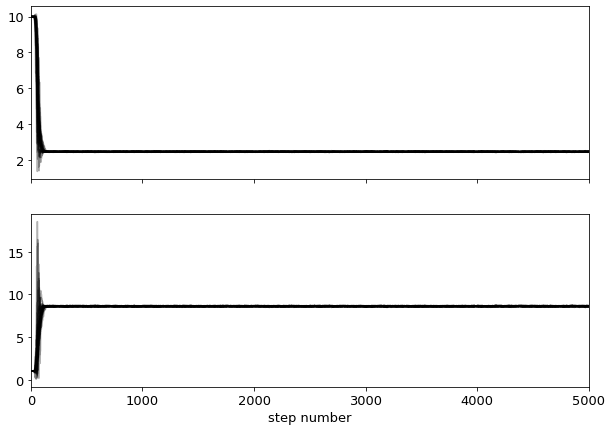

In [52]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [48]:
flat_samples = sampler.get_chain(discard=200, flat=True)
mcmc = np.zeros((ndim, 3))

#estraggo l'interquartile range, 1 sigma , 50 e 100-1sigma
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

#i valori al centro sono la mediana, e sono simili a quelli ottenuti ieri ok 



array([[2.46626752, 2.48040633, 2.49436568],
       [8.56005538, 8.5989751 , 8.6383954 ]])

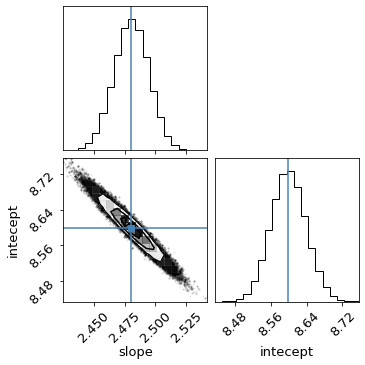

In [51]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=[ "slope","intecept"], truths=mcmc[:,1]);

#tutto nella norma
#possibili patologie: 
#bimodal,code significative, isolette ecc

##Compito: 
cambio il modello, al posto della linea metto un modello più motivato: 
BROKEN POWER LAW: una certa slope in un certo periodo e un altra in un altro periodo del tempo 

ATTENZIONE: il tempo ora torna normale, non più logaritmo!


dovrò mettere anche quest initial guess: b T a1 a2

[“b”, “Tb”, “a1”, “a2"] ==> initial guess [ 1.505e+01  2.736e+02  2.146e+00  3.548e+00]


50 walkers 
almeno 20k passi 